In [1]:
import torch                                  
import torch.nn as nn                         
import torch.nn.functional as F                 
import numpy as np                             
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import time
import copy

%matplotlib inline

In [2]:
miu = 3.03 * 10 ** (-2)
alphaM = 997 * 10 ** (-3)
alphaB = 1.66 * 10 ** (-2)
alphaA = 1.76 * 10 ** (4)
gammaM = 0.411
gammaB = 8.33 * 10 ** (-4)
gammaA = 1.35 * 10 ** (-2)
n = 2
K = 7200
K1 = 2.52 * 10 ** (-2)
KL = 0.97 * 10 ** (3)
KA = 1.95 * 10 ** (3)
betaA = 2.15 * 10 ** (4)
tauM = 0.1
tauB = 2.0
L = 50

In [3]:
tau = tauM + tauB
l = K1 ** (1/n) * L
tauMhat = tauM / tau
tauBhat = tauB / tau
miuhat = miu * tau
gammaMtilde = gammaM + miu
gammaBtilde = gammaB + miu
gammaAtilde = gammaA + miu
alphaMhat = tau * K1 ** (1/n) * alphaM
gammaMhat = tau * gammaMtilde
alphaBhat = tau * alphaB
gammaBhat = tau * gammaBtilde
kappa = K1 ** (1/n) * KA
alphaAhat = tau * alphaA
gammaAhat = tau * gammaAtilde
betaAhat = tau * betaA

In [4]:
BATCH_SIZE = 1                             
LR = 0.001                                     
N_ACTIONS = 3                
N_STATES = 3       
episode = 2500
dim = 3           
T = 3              
N = 100            
dt = T / N
discount = 1
seed = 10
number = 1
TAU = 0.1
sigma = 0.005
initial_point = torch.tensor((4.57 * 10 ** (-7), 2.29 * 10 ** (-7), 4.27 * 10 ** (-3)))
terminal_point = torch.tensor((3.28 * 10 ** (-5), 1.65 * 10 ** (-5), 6.47 * 10 ** (-2)))
MEMORY_CAPACITY = int(N * number)                         
plt.rc('font', family='serif')
fontdict_prop = {'family': 'serif', 'size': 20}

In [5]:
def propagate(x, u, t):
    
    delta_x = drift(x, u, t) * dt

    return x + delta_x

def drift(x, u, t):
    
    m = x[0]
    b = x[1]
    a = x[2]
    temp1 = 1 + K1 * (torch.e ** (- miu * tauM) * (a * (t - tauM))) ** n
    temp2 = K + K1 * (torch.e ** (- miu * tauM) * (a * (t - tauM))) ** n
    x_m = alphaM * temp1 / temp2 - gammaMtilde * m
    x_b = alphaB * torch.e ** (- miu * tauB) * m * (t - tauB) - gammaBtilde * b
    x_a = alphaA * b * L / (KL + L) - betaA * b * a / (KA + a) - gammaAtilde * a
    x = torch.tensor((x_m, x_b, x_a))

    return x + u

def derivative(state):
        
    m = state[0]
    b = state[1]
    a = state[2]
    dm = - gammaMtilde
    db = - gammaBtilde
    da = - betaA * b * KA / (KA + a) ** 2 - gammaAtilde
    
    return dm + db + da
       
def reward(x, u):     

    return (torch.sum(0.5 * torch.square(u)) / (sigma ** 2) + 0.5 * derivative(x)) * dt

def terminal_loss1(x, actor, index):
    
    s = x[0,:]

    y = copy.deepcopy(terminal_point)
    for i in range(N - index):
        a = actor(s)
        s_ = propagate(s, a, dt * index)
        s = s_
    
    s[0] = s[0] * 1e5
    s[1] = s[1] * 1e5  
    s[2] = s[2] * 1e2  
    y[0] = y[0] * 1e5
    y[1] = y[1] * 1e5  
    y[2] = y[2] * 1e2

    loss = nn.PairwiseDistance(p=2)(s, y)
    return loss

In [6]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 30)
        self.linear2 = nn.Linear(30, self.action_size)
        
    def forward(self, state):

        output = self.linear1(state)
        output = F.relu(output)
        output = self.linear2(output)
        output = torch.tanh(output)
        if output.shape==torch.Size([3]):
            output = output * torch.tensor([1e-3, 1e-5, 1e-1])

        if output.shape==torch.Size([1, 3]):
            output = output * torch.tensor([1e-3, 1e-5, 1e-1]).reshape(1, -1)

        return output

    
class Critic(nn.Module):
    def __init__(self, state_size, value_size):
        
        super(Critic, self).__init__()
        self.state_size = state_size
        self.linear1 = nn.Linear(self.state_size, 30)
        self.linear2 = nn.Linear(30, value_size)

    def forward(self, state):

        output = self.linear1(state)
        output = torch.arctan(output)
        output = self.linear2(output)
        
        return output

In [7]:
class AC(object):
    def __init__(self):                                                         
        self.actor = Actor(N_STATES, N_ACTIONS)
        self.actor_target = Actor(N_STATES, N_ACTIONS)
        self.critic = Critic(N_ACTIONS + N_STATES, 1)
        self.critic_target = Critic(N_ACTIONS + N_STATES, 1)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.memory_counter = 0                                                
        self.memory = torch.zeros((MEMORY_CAPACITY, 10))                          
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=LR)   
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=LR)

    def store_transition(self, s, a, r, s_):                                    
        transition = torch.cat((s.detach(), a.detach(), r.detach(), s_.detach()))  
        index = self.memory_counter % MEMORY_CAPACITY                          
        self.memory[index, :] = transition                                     
        self.memory_counter += 1                                               

    def learn(self, notion):  
        tra = []
        for i in range(N):
            tra.append(self.memory[[N*j+i for j in range(number)]])
        sample_index = np.random.choice(number, BATCH_SIZE)                    
        b_memory = tra[notion][sample_index, :]                                 
        b_s = b_memory[:, :N_STATES]                 
        b_a = b_memory[:, N_STATES:N_STATES+3]
        b_r = b_memory[:, N_STATES+3:N_STATES+4]
        b_s_ = b_memory[:, -N_STATES:]
            
        Q_cur = self.critic(torch.cat((b_s, b_a), 1))
        if notion == N-1:
            Q_next = torch.tensor(0., requires_grad=True)
        else:
            Q_next = self.critic_target(torch.cat((b_s_, self.actor_target(b_s_)), 1))
        td_error = b_r + discount * Q_next - Q_cur
        critic_loss = torch.mean(torch.square(td_error)) * 1e7 * sigma ** 2
        
        if notion == N-1:
            for j in range(4):
                self.optimizer_critic.zero_grad()
                critic_loss.backward(retain_graph=True)
                self.optimizer_critic.step()
                Q_cur = self.critic(torch.cat((b_s, b_a), 1))
                Q_next = torch.tensor(0., requires_grad=True)
                td_error = b_r + discount * Q_next - Q_cur
                critic_loss = torch.mean(torch.square(td_error)) * 1e7 * sigma ** 2
        else:
            for j in range(2):
                self.optimizer_critic.zero_grad()
                critic_loss.backward(retain_graph=True)
                self.optimizer_critic.step()
                Q_cur = self.critic(torch.cat((b_s, b_a), 1))
                Q_next = self.critic_target(torch.cat((b_s_, self.actor_target(b_s_)), 1))
                td_error = b_r + discount * Q_next - Q_cur
                critic_loss = torch.mean(torch.square(td_error)) * 1e7 * sigma ** 2
                
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
        
        Q_cur = self.critic(torch.cat((b_s, self.actor(b_s)), 1))
        actor_loss_ = torch.mean(Q_cur) * 500
        terminal_loss = terminal_loss1(b_s, self.actor, notion) * 100
        actor_loss = actor_loss_ + terminal_loss
        
        for j in range(1):
            self.optimizer_actor.zero_grad()
            actor_loss.backward()
            self.optimizer_actor.step()
            Q_cur = self.critic(torch.cat((b_s, self.actor(b_s)), 1))
            actor_loss_ = torch.mean(Q_cur) * 500
            terminal_loss = terminal_loss1(b_s, self.actor, notion) * 100
            actor_loss = actor_loss_ + terminal_loss
            
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        
        self.soft_update(self.critic, self.critic_target, TAU)
        self.soft_update(self.actor, self.actor_target, TAU)   
        
        return critic_loss.detach().numpy(), actor_loss.detach().numpy(), actor_loss_.detach().numpy(), terminal_loss.detach().numpy()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [8]:
torch.manual_seed(seed)
ac = AC()   
x0 = initial_point
memory = []
total_reward = []
reward1 = []
loss_critic = []
loss_actor = []
loss_terminal = []

In [9]:
start_time = time.time()
for i in range(episode):                                                   
    print('<<<<<<<<<Episode: %s' % i)
    s = initial_point
    episode_reward_sum = 0

    for j in range(N): 
        
        a = ac.actor(s)
        s_ = propagate(s, a, j * dt)
        r = reward(s, a)

        ac.store_transition(s, a, r.reshape(-1), s_)                   
        episode_reward_sum += r.detach().numpy()             

        s = s_                                               
        
        if ac.memory_counter > MEMORY_CAPACITY:            
            critic_loss, actor_loss, actor_loss_, terminal_loss = ac.learn(j)
            
            loss_critic.append(np.around(critic_loss, 2))
            loss_actor.append(np.around(actor_loss, 2))
            loss_terminal.append(np.around(terminal_loss, 2))
            
        else:
            critic_loss = 0
            actor_loss = 0
            actor_loss_ = 0
            terminal_loss = 0

        if j == N - 1:  
            print('episode: %s --- reward_sum: %s --- critic_loss: %s --- actor_loss: %s --- actor_loss_: %s --- terminal_loss: %s' 
                  % (i, round(episode_reward_sum, 2),  np.around(critic_loss, 2), np.around(actor_loss, 2), np.around(actor_loss_, 2)
                    , np.around(terminal_loss, 2)))
            print(round(time.time() - start_time, 2))

    temp = pd.DataFrame(ac.memory.detach().numpy())
    memory.append(copy.deepcopy(temp))
    total_reward.append(round(episode_reward_sum, 2))

<<<<<<<<<Episode: 0
episode: 0 --- reward_sum: 21.05 --- critic_loss: 0 --- actor_loss: 0 --- actor_loss_: 0 --- terminal_loss: 0
0.03
<<<<<<<<<Episode: 1
episode: 1 --- reward_sum: 35.78 --- critic_loss: 2081.19 --- actor_loss: 1693.76 --- actor_loss_: 1648.52 --- terminal_loss: 45.25
3.02
<<<<<<<<<Episode: 2
episode: 2 --- reward_sum: 11.04 --- critic_loss: 3010.87 --- actor_loss: 1748.58 --- actor_loss_: 1748.25 --- terminal_loss: 0.33
6.01
<<<<<<<<<Episode: 3
episode: 3 --- reward_sum: 11.58 --- critic_loss: 3572.58 --- actor_loss: 1909.13 --- actor_loss_: 1908.57 --- terminal_loss: 0.56
8.99
<<<<<<<<<Episode: 4
episode: 4 --- reward_sum: 11.26 --- critic_loss: 4084.96 --- actor_loss: 2038.98 --- actor_loss_: 2038.2 --- terminal_loss: 0.78
11.98
<<<<<<<<<Episode: 5
episode: 5 --- reward_sum: 11.37 --- critic_loss: 4573.51 --- actor_loss: 2155.44 --- actor_loss_: 2155.34 --- terminal_loss: 0.1
14.96
<<<<<<<<<Episode: 6
episode: 6 --- reward_sum: 11.31 --- critic_loss: 5025.12 --- ac

episode: 52 --- reward_sum: 11.26 --- critic_loss: 9494.99 --- actor_loss: 3099.9 --- actor_loss_: 3099.48 --- terminal_loss: 0.42
155.3
<<<<<<<<<Episode: 53
episode: 53 --- reward_sum: 11.24 --- critic_loss: 9453.31 --- actor_loss: 3093.58 --- actor_loss_: 3092.84 --- terminal_loss: 0.74
158.28
<<<<<<<<<Episode: 54
episode: 54 --- reward_sum: 11.24 --- critic_loss: 9406.76 --- actor_loss: 3085.63 --- actor_loss_: 3085.2 --- terminal_loss: 0.44
161.26
<<<<<<<<<Episode: 55
episode: 55 --- reward_sum: 11.2 --- critic_loss: 9357.69 --- actor_loss: 3077.4 --- actor_loss_: 3076.21 --- terminal_loss: 1.19
164.24
<<<<<<<<<Episode: 56
episode: 56 --- reward_sum: 11.26 --- critic_loss: 9298.74 --- actor_loss: 3068.14 --- actor_loss_: 3067.74 --- terminal_loss: 0.4
167.21
<<<<<<<<<Episode: 57
episode: 57 --- reward_sum: 11.23 --- critic_loss: 9243.05 --- actor_loss: 3058.83 --- actor_loss_: 3058.09 --- terminal_loss: 0.74
170.19
<<<<<<<<<Episode: 58
episode: 58 --- reward_sum: 11.2 --- critic_lo

episode: 104 --- reward_sum: 11.06 --- critic_loss: 2507.81 --- actor_loss: 1585.21 --- actor_loss_: 1584.88 --- terminal_loss: 0.33
310.41
<<<<<<<<<Episode: 105
episode: 105 --- reward_sum: 11.08 --- critic_loss: 2339.46 --- actor_loss: 1530.15 --- actor_loss_: 1530.0 --- terminal_loss: 0.15
313.39
<<<<<<<<<Episode: 106
episode: 106 --- reward_sum: 11.06 --- critic_loss: 2171.03 --- actor_loss: 1473.32 --- actor_loss_: 1473.17 --- terminal_loss: 0.14
316.37
<<<<<<<<<Episode: 107
episode: 107 --- reward_sum: 11.06 --- critic_loss: 2004.7 --- actor_loss: 1415.0 --- actor_loss_: 1414.89 --- terminal_loss: 0.11
319.34
<<<<<<<<<Episode: 108
episode: 108 --- reward_sum: 11.05 --- critic_loss: 1840.03 --- actor_loss: 1354.98 --- actor_loss_: 1354.66 --- terminal_loss: 0.32
322.3
<<<<<<<<<Episode: 109
episode: 109 --- reward_sum: 11.03 --- critic_loss: 1677.21 --- actor_loss: 1293.36 --- actor_loss_: 1292.72 --- terminal_loss: 0.65
325.27
<<<<<<<<<Episode: 110
episode: 110 --- reward_sum: 11.

episode: 157 --- reward_sum: 10.66 --- critic_loss: 0.61 --- actor_loss: 67.17 --- actor_loss_: 66.95 --- terminal_loss: 0.21
467.93
<<<<<<<<<Episode: 158
episode: 158 --- reward_sum: 10.68 --- critic_loss: 1.08 --- actor_loss: 68.61 --- actor_loss_: 68.42 --- terminal_loss: 0.19
470.9
<<<<<<<<<Episode: 159
episode: 159 --- reward_sum: 10.66 --- critic_loss: 2.29 --- actor_loss: 75.98 --- actor_loss_: 75.79 --- terminal_loss: 0.19
473.86
<<<<<<<<<Episode: 160
episode: 160 --- reward_sum: 10.66 --- critic_loss: 4.64 --- actor_loss: 97.82 --- actor_loss_: 97.63 --- terminal_loss: 0.19
476.83
<<<<<<<<<Episode: 161
episode: 161 --- reward_sum: 10.64 --- critic_loss: 5.29 --- actor_loss: 118.39 --- actor_loss_: 118.2 --- terminal_loss: 0.19
479.8
<<<<<<<<<Episode: 162
episode: 162 --- reward_sum: 10.65 --- critic_loss: 2.86 --- actor_loss: 108.45 --- actor_loss_: 108.35 --- terminal_loss: 0.1
482.88
<<<<<<<<<Episode: 163
episode: 163 --- reward_sum: 10.64 --- critic_loss: 1.32 --- actor_los

episode: 210 --- reward_sum: 10.35 --- critic_loss: 3.11 --- actor_loss: 82.53 --- actor_loss_: 82.45 --- terminal_loss: 0.09
626.08
<<<<<<<<<Episode: 211
episode: 211 --- reward_sum: 10.34 --- critic_loss: 3.28 --- actor_loss: 85.28 --- actor_loss_: 85.2 --- terminal_loss: 0.09
629.06
<<<<<<<<<Episode: 212
episode: 212 --- reward_sum: 10.33 --- critic_loss: 3.11 --- actor_loss: 85.29 --- actor_loss_: 85.22 --- terminal_loss: 0.07
632.04
<<<<<<<<<Episode: 213
episode: 213 --- reward_sum: 10.33 --- critic_loss: 2.79 --- actor_loss: 82.94 --- actor_loss_: 82.78 --- terminal_loss: 0.15
635.03
<<<<<<<<<Episode: 214
episode: 214 --- reward_sum: 10.33 --- critic_loss: 2.48 --- actor_loss: 78.92 --- actor_loss_: 78.77 --- terminal_loss: 0.16
638.02
<<<<<<<<<Episode: 215
episode: 215 --- reward_sum: 10.32 --- critic_loss: 2.44 --- actor_loss: 76.54 --- actor_loss_: 76.29 --- terminal_loss: 0.24
640.98
<<<<<<<<<Episode: 216
episode: 216 --- reward_sum: 10.32 --- critic_loss: 2.58 --- actor_loss

episode: 264 --- reward_sum: 10.37 --- critic_loss: 3.79 --- actor_loss: 73.32 --- actor_loss_: 73.18 --- terminal_loss: 0.14
786.88
<<<<<<<<<Episode: 265
episode: 265 --- reward_sum: 10.36 --- critic_loss: 3.79 --- actor_loss: 73.51 --- actor_loss_: 73.38 --- terminal_loss: 0.13
789.85
<<<<<<<<<Episode: 266
episode: 266 --- reward_sum: 10.35 --- critic_loss: 3.74 --- actor_loss: 73.32 --- actor_loss_: 73.2 --- terminal_loss: 0.12
792.82
<<<<<<<<<Episode: 267
episode: 267 --- reward_sum: 10.36 --- critic_loss: 3.63 --- actor_loss: 72.37 --- actor_loss_: 72.17 --- terminal_loss: 0.2
795.78
<<<<<<<<<Episode: 268
episode: 268 --- reward_sum: 10.34 --- critic_loss: 3.64 --- actor_loss: 72.15 --- actor_loss_: 71.93 --- terminal_loss: 0.22
798.75
<<<<<<<<<Episode: 269
episode: 269 --- reward_sum: 10.34 --- critic_loss: 3.69 --- actor_loss: 72.21 --- actor_loss_: 71.97 --- terminal_loss: 0.23
801.71
<<<<<<<<<Episode: 270
episode: 270 --- reward_sum: 10.34 --- critic_loss: 3.74 --- actor_loss:

episode: 318 --- reward_sum: 10.24 --- critic_loss: 3.96 --- actor_loss: 70.33 --- actor_loss_: 70.17 --- terminal_loss: 0.17
947.59
<<<<<<<<<Episode: 319
episode: 319 --- reward_sum: 10.24 --- critic_loss: 3.94 --- actor_loss: 70.36 --- actor_loss_: 69.96 --- terminal_loss: 0.4
950.55
<<<<<<<<<Episode: 320
episode: 320 --- reward_sum: 10.23 --- critic_loss: 3.93 --- actor_loss: 70.11 --- actor_loss_: 69.94 --- terminal_loss: 0.17
953.56
<<<<<<<<<Episode: 321
episode: 321 --- reward_sum: 10.22 --- critic_loss: 3.92 --- actor_loss: 69.89 --- actor_loss_: 69.83 --- terminal_loss: 0.06
956.53
<<<<<<<<<Episode: 322
episode: 322 --- reward_sum: 10.23 --- critic_loss: 3.91 --- actor_loss: 69.76 --- actor_loss_: 69.66 --- terminal_loss: 0.1
959.5
<<<<<<<<<Episode: 323
episode: 323 --- reward_sum: 10.22 --- critic_loss: 3.92 --- actor_loss: 69.54 --- actor_loss_: 69.48 --- terminal_loss: 0.05
962.47
<<<<<<<<<Episode: 324
episode: 324 --- reward_sum: 10.22 --- critic_loss: 3.94 --- actor_loss: 

episode: 371 --- reward_sum: 10.06 --- critic_loss: 3.91 --- actor_loss: 67.83 --- actor_loss_: 67.77 --- terminal_loss: 0.06
1105.52
<<<<<<<<<Episode: 372
episode: 372 --- reward_sum: 10.05 --- critic_loss: 3.95 --- actor_loss: 68.05 --- actor_loss_: 67.99 --- terminal_loss: 0.06
1108.49
<<<<<<<<<Episode: 373
episode: 373 --- reward_sum: 10.04 --- critic_loss: 3.98 --- actor_loss: 68.31 --- actor_loss_: 68.25 --- terminal_loss: 0.05
1111.46
<<<<<<<<<Episode: 374
episode: 374 --- reward_sum: 10.04 --- critic_loss: 4.01 --- actor_loss: 68.62 --- actor_loss_: 68.57 --- terminal_loss: 0.05
1114.43
<<<<<<<<<Episode: 375
episode: 375 --- reward_sum: 10.03 --- critic_loss: 4.04 --- actor_loss: 69.33 --- actor_loss_: 69.19 --- terminal_loss: 0.13
1117.4
<<<<<<<<<Episode: 376
episode: 376 --- reward_sum: 10.03 --- critic_loss: 3.89 --- actor_loss: 68.08 --- actor_loss_: 68.03 --- terminal_loss: 0.05
1120.37
<<<<<<<<<Episode: 377
episode: 377 --- reward_sum: 10.03 --- critic_loss: 3.84 --- acto

episode: 424 --- reward_sum: 9.84 --- critic_loss: 3.95 --- actor_loss: 67.53 --- actor_loss_: 67.4 --- terminal_loss: 0.13
1263.32
<<<<<<<<<Episode: 425
episode: 425 --- reward_sum: 9.82 --- critic_loss: 3.99 --- actor_loss: 67.82 --- actor_loss_: 67.74 --- terminal_loss: 0.08
1266.28
<<<<<<<<<Episode: 426
episode: 426 --- reward_sum: 9.83 --- critic_loss: 3.9 --- actor_loss: 67.28 --- actor_loss_: 67.23 --- terminal_loss: 0.05
1269.25
<<<<<<<<<Episode: 427
episode: 427 --- reward_sum: 9.82 --- critic_loss: 3.82 --- actor_loss: 66.55 --- actor_loss_: 66.5 --- terminal_loss: 0.05
1272.22
<<<<<<<<<Episode: 428
episode: 428 --- reward_sum: 9.83 --- critic_loss: 3.74 --- actor_loss: 65.57 --- actor_loss_: 65.51 --- terminal_loss: 0.06
1275.19
<<<<<<<<<Episode: 429
episode: 429 --- reward_sum: 9.82 --- critic_loss: 3.81 --- actor_loss: 65.59 --- actor_loss_: 65.54 --- terminal_loss: 0.05
1278.15
<<<<<<<<<Episode: 430
episode: 430 --- reward_sum: 9.82 --- critic_loss: 3.89 --- actor_loss: 6

episode: 478 --- reward_sum: 9.62 --- critic_loss: 3.84 --- actor_loss: 65.35 --- actor_loss_: 65.3 --- terminal_loss: 0.05
1423.83
<<<<<<<<<Episode: 479
episode: 479 --- reward_sum: 9.61 --- critic_loss: 3.86 --- actor_loss: 65.9 --- actor_loss_: 65.81 --- terminal_loss: 0.09
1426.8
<<<<<<<<<Episode: 480
episode: 480 --- reward_sum: 9.61 --- critic_loss: 3.76 --- actor_loss: 65.08 --- actor_loss_: 65.0 --- terminal_loss: 0.07
1429.78
<<<<<<<<<Episode: 481
episode: 481 --- reward_sum: 9.61 --- critic_loss: 3.72 --- actor_loss: 64.61 --- actor_loss_: 64.49 --- terminal_loss: 0.13
1432.74
<<<<<<<<<Episode: 482
episode: 482 --- reward_sum: 9.61 --- critic_loss: 3.72 --- actor_loss: 64.41 --- actor_loss_: 64.34 --- terminal_loss: 0.08
1435.71
<<<<<<<<<Episode: 483
episode: 483 --- reward_sum: 9.6 --- critic_loss: 3.77 --- actor_loss: 64.65 --- actor_loss_: 64.57 --- terminal_loss: 0.07
1438.69
<<<<<<<<<Episode: 484
episode: 484 --- reward_sum: 9.59 --- critic_loss: 3.84 --- actor_loss: 65.

episode: 532 --- reward_sum: 9.4 --- critic_loss: 3.68 --- actor_loss: 63.41 --- actor_loss_: 63.37 --- terminal_loss: 0.04
1584.59
<<<<<<<<<Episode: 533
episode: 533 --- reward_sum: 9.39 --- critic_loss: 3.68 --- actor_loss: 63.44 --- actor_loss_: 63.4 --- terminal_loss: 0.04
1587.55
<<<<<<<<<Episode: 534
episode: 534 --- reward_sum: 9.38 --- critic_loss: 3.66 --- actor_loss: 63.37 --- actor_loss_: 63.33 --- terminal_loss: 0.04
1590.54
<<<<<<<<<Episode: 535
episode: 535 --- reward_sum: 9.38 --- critic_loss: 3.64 --- actor_loss: 63.35 --- actor_loss_: 63.27 --- terminal_loss: 0.08
1593.53
<<<<<<<<<Episode: 536
episode: 536 --- reward_sum: 9.37 --- critic_loss: 3.64 --- actor_loss: 63.12 --- actor_loss_: 63.08 --- terminal_loss: 0.04
1596.51
<<<<<<<<<Episode: 537
episode: 537 --- reward_sum: 9.37 --- critic_loss: 3.68 --- actor_loss: 63.66 --- actor_loss_: 63.54 --- terminal_loss: 0.12
1599.49
<<<<<<<<<Episode: 538
episode: 538 --- reward_sum: 9.36 --- critic_loss: 3.64 --- actor_loss: 

episode: 586 --- reward_sum: 9.15 --- critic_loss: 3.49 --- actor_loss: 62.22 --- actor_loss_: 62.13 --- terminal_loss: 0.09
1745.63
<<<<<<<<<Episode: 587
episode: 587 --- reward_sum: 9.16 --- critic_loss: 3.38 --- actor_loss: 61.08 --- actor_loss_: 60.97 --- terminal_loss: 0.12
1748.6
<<<<<<<<<Episode: 588
episode: 588 --- reward_sum: 9.15 --- critic_loss: 3.41 --- actor_loss: 61.14 --- actor_loss_: 60.94 --- terminal_loss: 0.19
1751.58
<<<<<<<<<Episode: 589
episode: 589 --- reward_sum: 9.15 --- critic_loss: 3.48 --- actor_loss: 61.3 --- actor_loss_: 61.26 --- terminal_loss: 0.05
1754.57
<<<<<<<<<Episode: 590
episode: 590 --- reward_sum: 9.15 --- critic_loss: 3.55 --- actor_loss: 62.11 --- actor_loss_: 62.03 --- terminal_loss: 0.08
1757.54
<<<<<<<<<Episode: 591
episode: 591 --- reward_sum: 9.14 --- critic_loss: 3.57 --- actor_loss: 62.49 --- actor_loss_: 62.44 --- terminal_loss: 0.04
1760.51
<<<<<<<<<Episode: 592
episode: 592 --- reward_sum: 9.14 --- critic_loss: 3.5 --- actor_loss: 6

episode: 640 --- reward_sum: 8.92 --- critic_loss: 3.37 --- actor_loss: 61.04 --- actor_loss_: 60.9 --- terminal_loss: 0.14
1906.13
<<<<<<<<<Episode: 641
episode: 641 --- reward_sum: 8.91 --- critic_loss: 3.32 --- actor_loss: 60.68 --- actor_loss_: 60.61 --- terminal_loss: 0.06
1909.1
<<<<<<<<<Episode: 642
episode: 642 --- reward_sum: 8.9 --- critic_loss: 3.32 --- actor_loss: 60.86 --- actor_loss_: 60.76 --- terminal_loss: 0.09
1912.07
<<<<<<<<<Episode: 643
episode: 643 --- reward_sum: 8.9 --- critic_loss: 3.3 --- actor_loss: 60.73 --- actor_loss_: 60.58 --- terminal_loss: 0.15
1915.04
<<<<<<<<<Episode: 644
episode: 644 --- reward_sum: 8.89 --- critic_loss: 3.27 --- actor_loss: 60.29 --- actor_loss_: 60.25 --- terminal_loss: 0.04
1918.01
<<<<<<<<<Episode: 645
episode: 645 --- reward_sum: 8.89 --- critic_loss: 3.28 --- actor_loss: 60.33 --- actor_loss_: 60.28 --- terminal_loss: 0.05
1920.98
<<<<<<<<<Episode: 646
episode: 646 --- reward_sum: 8.88 --- critic_loss: 3.27 --- actor_loss: 60.

episode: 694 --- reward_sum: 8.65 --- critic_loss: 3.1 --- actor_loss: 59.21 --- actor_loss_: 59.14 --- terminal_loss: 0.06
2066.52
<<<<<<<<<Episode: 695
episode: 695 --- reward_sum: 8.64 --- critic_loss: 3.11 --- actor_loss: 59.35 --- actor_loss_: 59.23 --- terminal_loss: 0.12
2069.49
<<<<<<<<<Episode: 696
episode: 696 --- reward_sum: 8.63 --- critic_loss: 3.1 --- actor_loss: 59.25 --- actor_loss_: 59.17 --- terminal_loss: 0.08
2072.46
<<<<<<<<<Episode: 697
episode: 697 --- reward_sum: 8.63 --- critic_loss: 3.13 --- actor_loss: 59.69 --- actor_loss_: 59.63 --- terminal_loss: 0.06
2075.42
<<<<<<<<<Episode: 698
episode: 698 --- reward_sum: 8.62 --- critic_loss: 3.1 --- actor_loss: 59.63 --- actor_loss_: 59.5 --- terminal_loss: 0.13
2078.39
<<<<<<<<<Episode: 699
episode: 699 --- reward_sum: 8.61 --- critic_loss: 3.05 --- actor_loss: 59.12 --- actor_loss_: 58.98 --- terminal_loss: 0.14
2081.36
<<<<<<<<<Episode: 700
episode: 700 --- reward_sum: 8.61 --- critic_loss: 3.08 --- actor_loss: 59

episode: 748 --- reward_sum: 8.36 --- critic_loss: 2.85 --- actor_loss: 57.58 --- actor_loss_: 57.53 --- terminal_loss: 0.06
2226.85
<<<<<<<<<Episode: 749
episode: 749 --- reward_sum: 8.36 --- critic_loss: 2.87 --- actor_loss: 57.59 --- actor_loss_: 57.43 --- terminal_loss: 0.16
2229.82
<<<<<<<<<Episode: 750
episode: 750 --- reward_sum: 8.36 --- critic_loss: 2.89 --- actor_loss: 57.63 --- actor_loss_: 57.59 --- terminal_loss: 0.04
2232.79
<<<<<<<<<Episode: 751
episode: 751 --- reward_sum: 8.35 --- critic_loss: 2.92 --- actor_loss: 58.12 --- actor_loss_: 58.01 --- terminal_loss: 0.1
2235.76
<<<<<<<<<Episode: 752
episode: 752 --- reward_sum: 8.34 --- critic_loss: 2.91 --- actor_loss: 58.04 --- actor_loss_: 57.99 --- terminal_loss: 0.05
2238.73
<<<<<<<<<Episode: 753
episode: 753 --- reward_sum: 8.33 --- critic_loss: 2.89 --- actor_loss: 58.16 --- actor_loss_: 58.06 --- terminal_loss: 0.1
2241.7
<<<<<<<<<Episode: 754
episode: 754 --- reward_sum: 8.33 --- critic_loss: 2.85 --- actor_loss: 5

episode: 802 --- reward_sum: 8.08 --- critic_loss: 2.68 --- actor_loss: 56.15 --- actor_loss_: 56.11 --- terminal_loss: 0.04
2387.89
<<<<<<<<<Episode: 803
episode: 803 --- reward_sum: 8.08 --- critic_loss: 2.69 --- actor_loss: 56.26 --- actor_loss_: 56.21 --- terminal_loss: 0.05
2390.87
<<<<<<<<<Episode: 804
episode: 804 --- reward_sum: 8.07 --- critic_loss: 2.7 --- actor_loss: 56.44 --- actor_loss_: 56.28 --- terminal_loss: 0.15
2393.86
<<<<<<<<<Episode: 805
episode: 805 --- reward_sum: 8.07 --- critic_loss: 2.68 --- actor_loss: 56.27 --- actor_loss_: 56.21 --- terminal_loss: 0.06
2396.83
<<<<<<<<<Episode: 806
episode: 806 --- reward_sum: 8.06 --- critic_loss: 2.66 --- actor_loss: 56.05 --- actor_loss_: 55.95 --- terminal_loss: 0.1
2399.82
<<<<<<<<<Episode: 807
episode: 807 --- reward_sum: 8.06 --- critic_loss: 2.66 --- actor_loss: 55.94 --- actor_loss_: 55.89 --- terminal_loss: 0.04
2402.8
<<<<<<<<<Episode: 808
episode: 808 --- reward_sum: 8.06 --- critic_loss: 2.65 --- actor_loss: 5

episode: 856 --- reward_sum: 7.83 --- critic_loss: 2.47 --- actor_loss: 54.73 --- actor_loss_: 54.68 --- terminal_loss: 0.05
2548.36
<<<<<<<<<Episode: 857
episode: 857 --- reward_sum: 7.82 --- critic_loss: 2.46 --- actor_loss: 54.4 --- actor_loss_: 54.33 --- terminal_loss: 0.07
2551.34
<<<<<<<<<Episode: 858
episode: 858 --- reward_sum: 7.81 --- critic_loss: 2.48 --- actor_loss: 55.04 --- actor_loss_: 54.93 --- terminal_loss: 0.12
2554.32
<<<<<<<<<Episode: 859
episode: 859 --- reward_sum: 7.81 --- critic_loss: 2.46 --- actor_loss: 54.78 --- actor_loss_: 54.62 --- terminal_loss: 0.16
2557.3
<<<<<<<<<Episode: 860
episode: 860 --- reward_sum: 7.81 --- critic_loss: 2.46 --- actor_loss: 54.73 --- actor_loss_: 54.6 --- terminal_loss: 0.13
2560.28
<<<<<<<<<Episode: 861
episode: 861 --- reward_sum: 7.8 --- critic_loss: 2.47 --- actor_loss: 55.05 --- actor_loss_: 54.83 --- terminal_loss: 0.22
2563.26
<<<<<<<<<Episode: 862
episode: 862 --- reward_sum: 7.8 --- critic_loss: 2.44 --- actor_loss: 54.

episode: 910 --- reward_sum: 7.57 --- critic_loss: 2.27 --- actor_loss: 53.5 --- actor_loss_: 53.44 --- terminal_loss: 0.05
2709.09
<<<<<<<<<Episode: 911
episode: 911 --- reward_sum: 7.56 --- critic_loss: 2.26 --- actor_loss: 53.46 --- actor_loss_: 53.36 --- terminal_loss: 0.1
2712.06
<<<<<<<<<Episode: 912
episode: 912 --- reward_sum: 7.55 --- critic_loss: 2.27 --- actor_loss: 53.7 --- actor_loss_: 53.45 --- terminal_loss: 0.25
2715.04
<<<<<<<<<Episode: 913
episode: 913 --- reward_sum: 7.55 --- critic_loss: 2.26 --- actor_loss: 53.41 --- actor_loss_: 53.32 --- terminal_loss: 0.09
2718.03
<<<<<<<<<Episode: 914
episode: 914 --- reward_sum: 7.54 --- critic_loss: 2.27 --- actor_loss: 53.51 --- actor_loss_: 53.43 --- terminal_loss: 0.08
2721.0
<<<<<<<<<Episode: 915
episode: 915 --- reward_sum: 7.53 --- critic_loss: 2.3 --- actor_loss: 54.03 --- actor_loss_: 53.93 --- terminal_loss: 0.1
2723.96
<<<<<<<<<Episode: 916
episode: 916 --- reward_sum: 7.53 --- critic_loss: 2.26 --- actor_loss: 53.7

episode: 964 --- reward_sum: 7.28 --- critic_loss: 2.08 --- actor_loss: 51.94 --- actor_loss_: 51.88 --- terminal_loss: 0.06
2868.44
<<<<<<<<<Episode: 965
episode: 965 --- reward_sum: 7.27 --- critic_loss: 2.06 --- actor_loss: 51.63 --- actor_loss_: 51.5 --- terminal_loss: 0.13
2871.42
<<<<<<<<<Episode: 966
episode: 966 --- reward_sum: 7.27 --- critic_loss: 2.09 --- actor_loss: 51.72 --- actor_loss_: 51.63 --- terminal_loss: 0.09
2874.39
<<<<<<<<<Episode: 967
episode: 967 --- reward_sum: 7.26 --- critic_loss: 2.1 --- actor_loss: 51.95 --- actor_loss_: 51.75 --- terminal_loss: 0.2
2877.34
<<<<<<<<<Episode: 968
episode: 968 --- reward_sum: 7.26 --- critic_loss: 2.09 --- actor_loss: 51.75 --- actor_loss_: 51.67 --- terminal_loss: 0.09
2880.29
<<<<<<<<<Episode: 969
episode: 969 --- reward_sum: 7.26 --- critic_loss: 2.1 --- actor_loss: 51.89 --- actor_loss_: 51.73 --- terminal_loss: 0.16
2883.23
<<<<<<<<<Episode: 970
episode: 970 --- reward_sum: 7.26 --- critic_loss: 2.05 --- actor_loss: 51

episode: 1017 --- reward_sum: 7.08 --- critic_loss: 1.95 --- actor_loss: 50.11 --- actor_loss_: 49.99 --- terminal_loss: 0.12
3024.04
<<<<<<<<<Episode: 1018
episode: 1018 --- reward_sum: 7.08 --- critic_loss: 1.9 --- actor_loss: 49.32 --- actor_loss_: 49.25 --- terminal_loss: 0.08
3026.95
<<<<<<<<<Episode: 1019
episode: 1019 --- reward_sum: 7.08 --- critic_loss: 1.92 --- actor_loss: 49.15 --- actor_loss_: 49.0 --- terminal_loss: 0.15
3029.87
<<<<<<<<<Episode: 1020
episode: 1020 --- reward_sum: 7.08 --- critic_loss: 1.96 --- actor_loss: 49.39 --- actor_loss_: 49.32 --- terminal_loss: 0.07
3032.79
<<<<<<<<<Episode: 1021
episode: 1021 --- reward_sum: 7.07 --- critic_loss: 2.02 --- actor_loss: 50.16 --- actor_loss_: 49.99 --- terminal_loss: 0.17
3035.7
<<<<<<<<<Episode: 1022
episode: 1022 --- reward_sum: 7.07 --- critic_loss: 2.01 --- actor_loss: 50.36 --- actor_loss_: 50.23 --- terminal_loss: 0.13
3038.61
<<<<<<<<<Episode: 1023
episode: 1023 --- reward_sum: 7.07 --- critic_loss: 1.94 --- 

episode: 1070 --- reward_sum: 6.88 --- critic_loss: 1.85 --- actor_loss: 49.3 --- actor_loss_: 49.2 --- terminal_loss: 0.1
3180.38
<<<<<<<<<Episode: 1071
episode: 1071 --- reward_sum: 6.88 --- critic_loss: 1.83 --- actor_loss: 49.23 --- actor_loss_: 49.07 --- terminal_loss: 0.16
3183.33
<<<<<<<<<Episode: 1072
episode: 1072 --- reward_sum: 6.88 --- critic_loss: 1.79 --- actor_loss: 48.47 --- actor_loss_: 48.38 --- terminal_loss: 0.09
3186.28
<<<<<<<<<Episode: 1073
episode: 1073 --- reward_sum: 6.87 --- critic_loss: 1.8 --- actor_loss: 48.42 --- actor_loss_: 48.3 --- terminal_loss: 0.12
3189.22
<<<<<<<<<Episode: 1074
episode: 1074 --- reward_sum: 6.87 --- critic_loss: 1.82 --- actor_loss: 48.68 --- actor_loss_: 48.56 --- terminal_loss: 0.12
3192.16
<<<<<<<<<Episode: 1075
episode: 1075 --- reward_sum: 6.87 --- critic_loss: 1.84 --- actor_loss: 48.77 --- actor_loss_: 48.66 --- terminal_loss: 0.11
3195.11
<<<<<<<<<Episode: 1076
episode: 1076 --- reward_sum: 6.87 --- critic_loss: 1.85 --- ac

episode: 1123 --- reward_sum: 6.7 --- critic_loss: 1.78 --- actor_loss: 48.13 --- actor_loss_: 48.04 --- terminal_loss: 0.09
3336.25
<<<<<<<<<Episode: 1124
episode: 1124 --- reward_sum: 6.69 --- critic_loss: 1.84 --- actor_loss: 49.69 --- actor_loss_: 49.6 --- terminal_loss: 0.09
3339.18
<<<<<<<<<Episode: 1125
episode: 1125 --- reward_sum: 6.69 --- critic_loss: 1.76 --- actor_loss: 49.88 --- actor_loss_: 49.7 --- terminal_loss: 0.18
3342.12
<<<<<<<<<Episode: 1126
episode: 1126 --- reward_sum: 6.68 --- critic_loss: 1.61 --- actor_loss: 47.96 --- actor_loss_: 47.85 --- terminal_loss: 0.11
3345.06
<<<<<<<<<Episode: 1127
episode: 1127 --- reward_sum: 6.68 --- critic_loss: 1.55 --- actor_loss: 46.88 --- actor_loss_: 46.78 --- terminal_loss: 0.1
3347.98
<<<<<<<<<Episode: 1128
episode: 1128 --- reward_sum: 6.68 --- critic_loss: 1.59 --- actor_loss: 46.45 --- actor_loss_: 46.34 --- terminal_loss: 0.11
3350.91
<<<<<<<<<Episode: 1129
episode: 1129 --- reward_sum: 6.67 --- critic_loss: 1.7 --- ac

episode: 1176 --- reward_sum: 6.51 --- critic_loss: 1.67 --- actor_loss: 48.79 --- actor_loss_: 48.67 --- terminal_loss: 0.12
3493.01
<<<<<<<<<Episode: 1177
episode: 1177 --- reward_sum: 6.51 --- critic_loss: 1.62 --- actor_loss: 48.9 --- actor_loss_: 48.73 --- terminal_loss: 0.17
3495.99
<<<<<<<<<Episode: 1178
episode: 1178 --- reward_sum: 6.5 --- critic_loss: 1.52 --- actor_loss: 48.24 --- actor_loss_: 48.09 --- terminal_loss: 0.14
3498.96
<<<<<<<<<Episode: 1179
episode: 1179 --- reward_sum: 6.5 --- critic_loss: 1.43 --- actor_loss: 46.31 --- actor_loss_: 46.19 --- terminal_loss: 0.12
3501.94
<<<<<<<<<Episode: 1180
episode: 1180 --- reward_sum: 6.5 --- critic_loss: 1.45 --- actor_loss: 46.23 --- actor_loss_: 46.06 --- terminal_loss: 0.17
3504.91
<<<<<<<<<Episode: 1181
episode: 1181 --- reward_sum: 6.5 --- critic_loss: 1.52 --- actor_loss: 46.79 --- actor_loss_: 46.68 --- terminal_loss: 0.11
3507.89
<<<<<<<<<Episode: 1182
episode: 1182 --- reward_sum: 6.49 --- critic_loss: 1.6 --- act

episode: 1229 --- reward_sum: 6.35 --- critic_loss: 1.5 --- actor_loss: 46.99 --- actor_loss_: 46.79 --- terminal_loss: 0.2
3650.1
<<<<<<<<<Episode: 1230
episode: 1230 --- reward_sum: 6.35 --- critic_loss: 1.53 --- actor_loss: 48.26 --- actor_loss_: 48.07 --- terminal_loss: 0.2
3653.08
<<<<<<<<<Episode: 1231
episode: 1231 --- reward_sum: 6.35 --- critic_loss: 1.42 --- actor_loss: 47.25 --- actor_loss_: 47.12 --- terminal_loss: 0.14
3656.06
<<<<<<<<<Episode: 1232
episode: 1232 --- reward_sum: 6.35 --- critic_loss: 1.33 --- actor_loss: 45.84 --- actor_loss_: 45.68 --- terminal_loss: 0.15
3659.03
<<<<<<<<<Episode: 1233
episode: 1233 --- reward_sum: 6.35 --- critic_loss: 1.33 --- actor_loss: 45.38 --- actor_loss_: 45.22 --- terminal_loss: 0.16
3662.0
<<<<<<<<<Episode: 1234
episode: 1234 --- reward_sum: 6.34 --- critic_loss: 1.39 --- actor_loss: 45.87 --- actor_loss_: 45.75 --- terminal_loss: 0.12
3664.98
<<<<<<<<<Episode: 1235
episode: 1235 --- reward_sum: 6.34 --- critic_loss: 1.47 --- ac

episode: 1282 --- reward_sum: 6.19 --- critic_loss: 1.36 --- actor_loss: 47.77 --- actor_loss_: 47.59 --- terminal_loss: 0.19
3807.67
<<<<<<<<<Episode: 1283
episode: 1283 --- reward_sum: 6.19 --- critic_loss: 1.29 --- actor_loss: 47.07 --- actor_loss_: 46.88 --- terminal_loss: 0.2
3810.63
<<<<<<<<<Episode: 1284
episode: 1284 --- reward_sum: 6.18 --- critic_loss: 1.23 --- actor_loss: 46.13 --- actor_loss_: 45.99 --- terminal_loss: 0.13
3813.6
<<<<<<<<<Episode: 1285
episode: 1285 --- reward_sum: 6.18 --- critic_loss: 1.22 --- actor_loss: 45.6 --- actor_loss_: 45.47 --- terminal_loss: 0.13
3816.56
<<<<<<<<<Episode: 1286
episode: 1286 --- reward_sum: 6.17 --- critic_loss: 1.27 --- actor_loss: 45.98 --- actor_loss_: 45.85 --- terminal_loss: 0.13
3819.52
<<<<<<<<<Episode: 1287
episode: 1287 --- reward_sum: 6.17 --- critic_loss: 1.33 --- actor_loss: 46.9 --- actor_loss_: 46.75 --- terminal_loss: 0.15
3822.48
<<<<<<<<<Episode: 1288
episode: 1288 --- reward_sum: 6.17 --- critic_loss: 1.33 --- a

episode: 1335 --- reward_sum: 6.04 --- critic_loss: 1.11 --- actor_loss: 45.98 --- actor_loss_: 45.78 --- terminal_loss: 0.2
3964.17
<<<<<<<<<Episode: 1336
episode: 1336 --- reward_sum: 6.03 --- critic_loss: 1.13 --- actor_loss: 46.01 --- actor_loss_: 45.78 --- terminal_loss: 0.23
3967.15
<<<<<<<<<Episode: 1337
episode: 1337 --- reward_sum: 6.03 --- critic_loss: 1.17 --- actor_loss: 46.53 --- actor_loss_: 46.29 --- terminal_loss: 0.24
3970.13
<<<<<<<<<Episode: 1338
episode: 1338 --- reward_sum: 6.03 --- critic_loss: 1.19 --- actor_loss: 47.07 --- actor_loss_: 46.84 --- terminal_loss: 0.23
3973.1
<<<<<<<<<Episode: 1339
episode: 1339 --- reward_sum: 6.03 --- critic_loss: 1.15 --- actor_loss: 46.47 --- actor_loss_: 46.3 --- terminal_loss: 0.17
3976.08
<<<<<<<<<Episode: 1340
episode: 1340 --- reward_sum: 6.03 --- critic_loss: 1.14 --- actor_loss: 46.6 --- actor_loss_: 46.43 --- terminal_loss: 0.17
3979.06
<<<<<<<<<Episode: 1341
episode: 1341 --- reward_sum: 6.02 --- critic_loss: 1.13 --- a

episode: 1388 --- reward_sum: 5.9 --- critic_loss: 1.05 --- actor_loss: 47.12 --- actor_loss_: 46.9 --- terminal_loss: 0.22
4121.88
<<<<<<<<<Episode: 1389
episode: 1389 --- reward_sum: 5.89 --- critic_loss: 1.05 --- actor_loss: 47.62 --- actor_loss_: 47.36 --- terminal_loss: 0.27
4124.83
<<<<<<<<<Episode: 1390
episode: 1390 --- reward_sum: 5.89 --- critic_loss: 1.02 --- actor_loss: 47.36 --- actor_loss_: 47.17 --- terminal_loss: 0.19
4127.78
<<<<<<<<<Episode: 1391
episode: 1391 --- reward_sum: 5.89 --- critic_loss: 0.97 --- actor_loss: 46.55 --- actor_loss_: 46.37 --- terminal_loss: 0.17
4130.76
<<<<<<<<<Episode: 1392
episode: 1392 --- reward_sum: 5.89 --- critic_loss: 0.96 --- actor_loss: 46.38 --- actor_loss_: 46.1 --- terminal_loss: 0.28
4133.71
<<<<<<<<<Episode: 1393
episode: 1393 --- reward_sum: 5.88 --- critic_loss: 0.98 --- actor_loss: 46.39 --- actor_loss_: 46.21 --- terminal_loss: 0.17
4136.66
<<<<<<<<<Episode: 1394
episode: 1394 --- reward_sum: 5.88 --- critic_loss: 1.0 --- a

episode: 1441 --- reward_sum: 5.79 --- critic_loss: 0.85 --- actor_loss: 45.57 --- actor_loss_: 45.38 --- terminal_loss: 0.19
4278.56
<<<<<<<<<Episode: 1442
episode: 1442 --- reward_sum: 5.79 --- critic_loss: 0.93 --- actor_loss: 46.76 --- actor_loss_: 46.57 --- terminal_loss: 0.19
4281.5
<<<<<<<<<Episode: 1443
episode: 1443 --- reward_sum: 5.78 --- critic_loss: 1.01 --- actor_loss: 48.76 --- actor_loss_: 48.51 --- terminal_loss: 0.25
4284.45
<<<<<<<<<Episode: 1444
episode: 1444 --- reward_sum: 5.78 --- critic_loss: 0.98 --- actor_loss: 49.22 --- actor_loss_: 48.98 --- terminal_loss: 0.24
4287.39
<<<<<<<<<Episode: 1445
episode: 1445 --- reward_sum: 5.77 --- critic_loss: 0.87 --- actor_loss: 47.96 --- actor_loss_: 47.79 --- terminal_loss: 0.17
4290.35
<<<<<<<<<Episode: 1446
episode: 1446 --- reward_sum: 5.77 --- critic_loss: 0.79 --- actor_loss: 46.7 --- actor_loss_: 46.43 --- terminal_loss: 0.27
4293.33
<<<<<<<<<Episode: 1447
episode: 1447 --- reward_sum: 5.77 --- critic_loss: 0.77 ---

episode: 1494 --- reward_sum: 5.69 --- critic_loss: 0.75 --- actor_loss: 49.2 --- actor_loss_: 49.0 --- terminal_loss: 0.21
4436.14
<<<<<<<<<Episode: 1495
episode: 1495 --- reward_sum: 5.69 --- critic_loss: 0.58 --- actor_loss: 45.78 --- actor_loss_: 45.58 --- terminal_loss: 0.2
4439.12
<<<<<<<<<Episode: 1496
episode: 1496 --- reward_sum: 5.68 --- critic_loss: 0.54 --- actor_loss: 43.6 --- actor_loss_: 43.29 --- terminal_loss: 0.31
4442.15
<<<<<<<<<Episode: 1497
episode: 1497 --- reward_sum: 5.68 --- critic_loss: 0.63 --- actor_loss: 43.81 --- actor_loss_: 43.55 --- terminal_loss: 0.26
4445.15
<<<<<<<<<Episode: 1498
episode: 1498 --- reward_sum: 5.68 --- critic_loss: 0.82 --- actor_loss: 46.01 --- actor_loss_: 45.7 --- terminal_loss: 0.31
4448.12
<<<<<<<<<Episode: 1499
episode: 1499 --- reward_sum: 5.68 --- critic_loss: 1.02 --- actor_loss: 49.6 --- actor_loss_: 49.3 --- terminal_loss: 0.31
4451.1
<<<<<<<<<Episode: 1500
episode: 1500 --- reward_sum: 5.69 --- critic_loss: 1.02 --- actor

episode: 1547 --- reward_sum: 5.61 --- critic_loss: 0.26 --- actor_loss: 39.68 --- actor_loss_: 39.46 --- terminal_loss: 0.22
4594.05
<<<<<<<<<Episode: 1548
episode: 1548 --- reward_sum: 5.61 --- critic_loss: 0.38 --- actor_loss: 40.09 --- actor_loss_: 39.85 --- terminal_loss: 0.24
4597.03
<<<<<<<<<Episode: 1549
episode: 1549 --- reward_sum: 5.61 --- critic_loss: 0.7 --- actor_loss: 44.16 --- actor_loss_: 43.83 --- terminal_loss: 0.33
4600.01
<<<<<<<<<Episode: 1550
episode: 1550 --- reward_sum: 5.6 --- critic_loss: 1.22 --- actor_loss: 52.84 --- actor_loss_: 52.42 --- terminal_loss: 0.42
4602.99
<<<<<<<<<Episode: 1551
episode: 1551 --- reward_sum: 5.61 --- critic_loss: 1.25 --- actor_loss: 59.91 --- actor_loss_: 59.64 --- terminal_loss: 0.27
4605.97
<<<<<<<<<Episode: 1552
episode: 1552 --- reward_sum: 5.61 --- critic_loss: 0.62 --- actor_loss: 52.16 --- actor_loss_: 51.95 --- terminal_loss: 0.2
4608.95
<<<<<<<<<Episode: 1553
episode: 1553 --- reward_sum: 5.61 --- critic_loss: 0.27 --- 

episode: 1600 --- reward_sum: 5.57 --- critic_loss: 0.17 --- actor_loss: 41.71 --- actor_loss_: 41.45 --- terminal_loss: 0.26
4751.92
<<<<<<<<<Episode: 1601
episode: 1601 --- reward_sum: 5.57 --- critic_loss: 0.11 --- actor_loss: 37.58 --- actor_loss_: 37.27 --- terminal_loss: 0.31
4754.89
<<<<<<<<<Episode: 1602
episode: 1602 --- reward_sum: 5.57 --- critic_loss: 0.14 --- actor_loss: 37.33 --- actor_loss_: 37.09 --- terminal_loss: 0.24
4757.86
<<<<<<<<<Episode: 1603
episode: 1603 --- reward_sum: 5.57 --- critic_loss: 0.26 --- actor_loss: 38.35 --- actor_loss_: 38.02 --- terminal_loss: 0.33
4760.83
<<<<<<<<<Episode: 1604
episode: 1604 --- reward_sum: 5.57 --- critic_loss: 0.57 --- actor_loss: 41.74 --- actor_loss_: 41.48 --- terminal_loss: 0.26
4763.81
<<<<<<<<<Episode: 1605
episode: 1605 --- reward_sum: 5.56 --- critic_loss: 1.33 --- actor_loss: 54.63 --- actor_loss_: 54.31 --- terminal_loss: 0.32
4766.78
<<<<<<<<<Episode: 1606
episode: 1606 --- reward_sum: 5.56 --- critic_loss: 1.44 -

episode: 1653 --- reward_sum: 5.54 --- critic_loss: 0.26 --- actor_loss: 37.26 --- actor_loss_: 36.9 --- terminal_loss: 0.36
4909.49
<<<<<<<<<Episode: 1654
episode: 1654 --- reward_sum: 5.54 --- critic_loss: 0.7 --- actor_loss: 42.25 --- actor_loss_: 41.95 --- terminal_loss: 0.3
4912.47
<<<<<<<<<Episode: 1655
episode: 1655 --- reward_sum: 5.54 --- critic_loss: 1.67 --- actor_loss: 60.44 --- actor_loss_: 60.08 --- terminal_loss: 0.36
4915.47
<<<<<<<<<Episode: 1656
episode: 1656 --- reward_sum: 5.54 --- critic_loss: 1.23 --- actor_loss: 65.8 --- actor_loss_: 65.44 --- terminal_loss: 0.36
4918.46
<<<<<<<<<Episode: 1657
episode: 1657 --- reward_sum: 5.54 --- critic_loss: 0.32 --- actor_loss: 49.82 --- actor_loss_: 49.49 --- terminal_loss: 0.33
4921.45
<<<<<<<<<Episode: 1658
episode: 1658 --- reward_sum: 5.54 --- critic_loss: 0.09 --- actor_loss: 38.61 --- actor_loss_: 38.25 --- terminal_loss: 0.35
4924.42
<<<<<<<<<Episode: 1659
episode: 1659 --- reward_sum: 5.53 --- critic_loss: 0.07 --- a

episode: 1706 --- reward_sum: 5.52 --- critic_loss: 0.92 --- actor_loss: 62.61 --- actor_loss_: 62.32 --- terminal_loss: 0.29
5067.23
<<<<<<<<<Episode: 1707
episode: 1707 --- reward_sum: 5.52 --- critic_loss: 0.19 --- actor_loss: 44.44 --- actor_loss_: 44.17 --- terminal_loss: 0.28
5070.21
<<<<<<<<<Episode: 1708
episode: 1708 --- reward_sum: 5.51 --- critic_loss: 0.06 --- actor_loss: 35.45 --- actor_loss_: 35.12 --- terminal_loss: 0.33
5073.2
<<<<<<<<<Episode: 1709
episode: 1709 --- reward_sum: 5.52 --- critic_loss: 0.07 --- actor_loss: 35.68 --- actor_loss_: 35.33 --- terminal_loss: 0.35
5076.18
<<<<<<<<<Episode: 1710
episode: 1710 --- reward_sum: 5.52 --- critic_loss: 0.11 --- actor_loss: 36.01 --- actor_loss_: 35.67 --- terminal_loss: 0.35
5079.16
<<<<<<<<<Episode: 1711
episode: 1711 --- reward_sum: 5.52 --- critic_loss: 0.23 --- actor_loss: 37.04 --- actor_loss_: 36.67 --- terminal_loss: 0.37
5082.14
<<<<<<<<<Episode: 1712
episode: 1712 --- reward_sum: 5.51 --- critic_loss: 0.6 ---

episode: 1759 --- reward_sum: 5.5 --- critic_loss: 0.09 --- actor_loss: 35.33 --- actor_loss_: 35.03 --- terminal_loss: 0.3
5224.92
<<<<<<<<<Episode: 1760
episode: 1760 --- reward_sum: 5.5 --- critic_loss: 0.17 --- actor_loss: 36.38 --- actor_loss_: 35.95 --- terminal_loss: 0.43
5227.9
<<<<<<<<<Episode: 1761
episode: 1761 --- reward_sum: 5.5 --- critic_loss: 0.43 --- actor_loss: 39.08 --- actor_loss_: 38.84 --- terminal_loss: 0.24
5230.88
<<<<<<<<<Episode: 1762
episode: 1762 --- reward_sum: 5.49 --- critic_loss: 1.14 --- actor_loss: 49.46 --- actor_loss_: 49.02 --- terminal_loss: 0.44
5233.85
<<<<<<<<<Episode: 1763
episode: 1763 --- reward_sum: 5.5 --- critic_loss: 1.69 --- actor_loss: 66.2 --- actor_loss_: 65.86 --- terminal_loss: 0.34
5236.83
<<<<<<<<<Episode: 1764
episode: 1764 --- reward_sum: 5.5 --- critic_loss: 0.64 --- actor_loss: 57.34 --- actor_loss_: 56.94 --- terminal_loss: 0.4
5239.82
<<<<<<<<<Episode: 1765
episode: 1765 --- reward_sum: 5.49 --- critic_loss: 0.13 --- actor_

episode: 1812 --- reward_sum: 5.48 --- critic_loss: 1.68 --- actor_loss: 67.34 --- actor_loss_: 66.96 --- terminal_loss: 0.38
5382.93
<<<<<<<<<Episode: 1813
episode: 1813 --- reward_sum: 5.48 --- critic_loss: 0.57 --- actor_loss: 56.06 --- actor_loss_: 55.68 --- terminal_loss: 0.38
5385.91
<<<<<<<<<Episode: 1814
episode: 1814 --- reward_sum: 5.48 --- critic_loss: 0.11 --- actor_loss: 39.3 --- actor_loss_: 38.96 --- terminal_loss: 0.33
5388.89
<<<<<<<<<Episode: 1815
episode: 1815 --- reward_sum: 5.47 --- critic_loss: 0.06 --- actor_loss: 35.89 --- actor_loss_: 35.41 --- terminal_loss: 0.48
5391.86
<<<<<<<<<Episode: 1816
episode: 1816 --- reward_sum: 5.48 --- critic_loss: 0.08 --- actor_loss: 35.53 --- actor_loss_: 35.17 --- terminal_loss: 0.36
5394.84
<<<<<<<<<Episode: 1817
episode: 1817 --- reward_sum: 5.47 --- critic_loss: 0.14 --- actor_loss: 35.93 --- actor_loss_: 35.54 --- terminal_loss: 0.39
5397.82
<<<<<<<<<Episode: 1818
episode: 1818 --- reward_sum: 5.47 --- critic_loss: 0.35 --

episode: 1865 --- reward_sum: 5.46 --- critic_loss: 0.08 --- actor_loss: 34.8 --- actor_loss_: 34.4 --- terminal_loss: 0.4
5541.07
<<<<<<<<<Episode: 1866
episode: 1866 --- reward_sum: 5.46 --- critic_loss: 0.16 --- actor_loss: 35.83 --- actor_loss_: 35.25 --- terminal_loss: 0.58
5544.07
<<<<<<<<<Episode: 1867
episode: 1867 --- reward_sum: 5.46 --- critic_loss: 0.39 --- actor_loss: 37.84 --- actor_loss_: 37.49 --- terminal_loss: 0.36
5547.06
<<<<<<<<<Episode: 1868
episode: 1868 --- reward_sum: 5.46 --- critic_loss: 1.15 --- actor_loss: 49.07 --- actor_loss_: 48.72 --- terminal_loss: 0.35
5550.05
<<<<<<<<<Episode: 1869
episode: 1869 --- reward_sum: 5.46 --- critic_loss: 1.73 --- actor_loss: 66.83 --- actor_loss_: 66.45 --- terminal_loss: 0.38
5553.04
<<<<<<<<<Episode: 1870
episode: 1870 --- reward_sum: 5.46 --- critic_loss: 0.59 --- actor_loss: 55.82 --- actor_loss_: 55.47 --- terminal_loss: 0.35
5556.04
<<<<<<<<<Episode: 1871
episode: 1871 --- reward_sum: 5.46 --- critic_loss: 0.11 --- 

episode: 1918 --- reward_sum: 5.45 --- critic_loss: 0.63 --- actor_loss: 57.05 --- actor_loss_: 56.57 --- terminal_loss: 0.48
5699.32
<<<<<<<<<Episode: 1919
episode: 1919 --- reward_sum: 5.45 --- critic_loss: 0.11 --- actor_loss: 39.09 --- actor_loss_: 38.73 --- terminal_loss: 0.36
5702.3
<<<<<<<<<Episode: 1920
episode: 1920 --- reward_sum: 5.45 --- critic_loss: 0.06 --- actor_loss: 34.63 --- actor_loss_: 34.08 --- terminal_loss: 0.55
5705.29
<<<<<<<<<Episode: 1921
episode: 1921 --- reward_sum: 5.44 --- critic_loss: 0.08 --- actor_loss: 34.86 --- actor_loss_: 34.28 --- terminal_loss: 0.58
5708.29
<<<<<<<<<Episode: 1922
episode: 1922 --- reward_sum: 5.45 --- critic_loss: 0.17 --- actor_loss: 36.49 --- actor_loss_: 36.01 --- terminal_loss: 0.48
5711.27
<<<<<<<<<Episode: 1923
episode: 1923 --- reward_sum: 5.45 --- critic_loss: 0.39 --- actor_loss: 38.87 --- actor_loss_: 38.42 --- terminal_loss: 0.45
5714.26
<<<<<<<<<Episode: 1924
episode: 1924 --- reward_sum: 5.45 --- critic_loss: 1.07 --

episode: 1971 --- reward_sum: 5.44 --- critic_loss: 0.34 --- actor_loss: 37.31 --- actor_loss_: 36.82 --- terminal_loss: 0.49
5857.75
<<<<<<<<<Episode: 1972
episode: 1972 --- reward_sum: 5.44 --- critic_loss: 0.95 --- actor_loss: 45.77 --- actor_loss_: 45.33 --- terminal_loss: 0.45
5860.74
<<<<<<<<<Episode: 1973
episode: 1973 --- reward_sum: 5.44 --- critic_loss: 1.75 --- actor_loss: 64.6 --- actor_loss_: 64.2 --- terminal_loss: 0.39
5863.73
<<<<<<<<<Episode: 1974
episode: 1974 --- reward_sum: 5.44 --- critic_loss: 0.72 --- actor_loss: 57.48 --- actor_loss_: 57.14 --- terminal_loss: 0.33
5866.72
<<<<<<<<<Episode: 1975
episode: 1975 --- reward_sum: 5.44 --- critic_loss: 0.14 --- actor_loss: 40.35 --- actor_loss_: 39.97 --- terminal_loss: 0.38
5869.71
<<<<<<<<<Episode: 1976
episode: 1976 --- reward_sum: 5.44 --- critic_loss: 0.06 --- actor_loss: 34.74 --- actor_loss_: 34.35 --- terminal_loss: 0.39
5872.69
<<<<<<<<<Episode: 1977
episode: 1977 --- reward_sum: 5.44 --- critic_loss: 0.08 ---

episode: 2024 --- reward_sum: 5.42 --- critic_loss: 0.05 --- actor_loss: 33.88 --- actor_loss_: 33.58 --- terminal_loss: 0.3
6015.93
<<<<<<<<<Episode: 2025
episode: 2025 --- reward_sum: 5.42 --- critic_loss: 0.09 --- actor_loss: 35.16 --- actor_loss_: 34.74 --- terminal_loss: 0.42
6018.91
<<<<<<<<<Episode: 2026
episode: 2026 --- reward_sum: 5.41 --- critic_loss: 0.2 --- actor_loss: 36.79 --- actor_loss_: 36.21 --- terminal_loss: 0.58
6021.9
<<<<<<<<<Episode: 2027
episode: 2027 --- reward_sum: 5.42 --- critic_loss: 0.54 --- actor_loss: 40.1 --- actor_loss_: 39.74 --- terminal_loss: 0.36
6024.88
<<<<<<<<<Episode: 2028
episode: 2028 --- reward_sum: 5.42 --- critic_loss: 1.43 --- actor_loss: 56.19 --- actor_loss_: 55.7 --- terminal_loss: 0.49
6027.85
<<<<<<<<<Episode: 2029
episode: 2029 --- reward_sum: 5.42 --- critic_loss: 1.3 --- actor_loss: 65.21 --- actor_loss_: 64.64 --- terminal_loss: 0.57
6030.83
<<<<<<<<<Episode: 2030
episode: 2030 --- reward_sum: 5.42 --- critic_loss: 0.31 --- act

episode: 2077 --- reward_sum: 5.42 --- critic_loss: 0.53 --- actor_loss: 54.16 --- actor_loss_: 53.4 --- terminal_loss: 0.76
6173.75
<<<<<<<<<Episode: 2078
episode: 2078 --- reward_sum: 5.41 --- critic_loss: 0.09 --- actor_loss: 37.04 --- actor_loss_: 36.49 --- terminal_loss: 0.55
6176.73
<<<<<<<<<Episode: 2079
episode: 2079 --- reward_sum: 5.41 --- critic_loss: 0.05 --- actor_loss: 33.55 --- actor_loss_: 33.21 --- terminal_loss: 0.34
6179.71
<<<<<<<<<Episode: 2080
episode: 2080 --- reward_sum: 5.41 --- critic_loss: 0.09 --- actor_loss: 34.27 --- actor_loss_: 33.92 --- terminal_loss: 0.36
6182.69
<<<<<<<<<Episode: 2081
episode: 2081 --- reward_sum: 5.4 --- critic_loss: 0.17 --- actor_loss: 35.1 --- actor_loss_: 34.4 --- terminal_loss: 0.7
6185.67
<<<<<<<<<Episode: 2082
episode: 2082 --- reward_sum: 5.41 --- critic_loss: 0.48 --- actor_loss: 39.27 --- actor_loss_: 38.69 --- terminal_loss: 0.58
6188.63
<<<<<<<<<Episode: 2083
episode: 2083 --- reward_sum: 5.41 --- critic_loss: 1.28 --- ac

episode: 2130 --- reward_sum: 5.4 --- critic_loss: 1.41 --- actor_loss: 56.56 --- actor_loss_: 56.02 --- terminal_loss: 0.54
6331.38
<<<<<<<<<Episode: 2131
episode: 2131 --- reward_sum: 5.4 --- critic_loss: 1.18 --- actor_loss: 63.49 --- actor_loss_: 63.05 --- terminal_loss: 0.44
6334.31
<<<<<<<<<Episode: 2132
episode: 2132 --- reward_sum: 5.4 --- critic_loss: 0.29 --- actor_loss: 47.25 --- actor_loss_: 46.71 --- terminal_loss: 0.53
6337.24
<<<<<<<<<Episode: 2133
episode: 2133 --- reward_sum: 5.39 --- critic_loss: 0.07 --- actor_loss: 35.93 --- actor_loss_: 35.22 --- terminal_loss: 0.71
6340.17
<<<<<<<<<Episode: 2134
episode: 2134 --- reward_sum: 5.4 --- critic_loss: 0.07 --- actor_loss: 35.25 --- actor_loss_: 34.79 --- terminal_loss: 0.46
6343.09
<<<<<<<<<Episode: 2135
episode: 2135 --- reward_sum: 5.4 --- critic_loss: 0.12 --- actor_loss: 35.52 --- actor_loss_: 35.06 --- terminal_loss: 0.45
6346.02
<<<<<<<<<Episode: 2136
episode: 2136 --- reward_sum: 5.4 --- critic_loss: 0.26 --- act

episode: 2183 --- reward_sum: 5.4 --- critic_loss: 0.41 --- actor_loss: 38.99 --- actor_loss_: 38.37 --- terminal_loss: 0.61
6487.7
<<<<<<<<<Episode: 2184
episode: 2184 --- reward_sum: 5.4 --- critic_loss: 1.12 --- actor_loss: 50.02 --- actor_loss_: 49.46 --- terminal_loss: 0.55
6490.65
<<<<<<<<<Episode: 2185
episode: 2185 --- reward_sum: 5.4 --- critic_loss: 1.48 --- actor_loss: 63.55 --- actor_loss_: 63.01 --- terminal_loss: 0.55
6493.61
<<<<<<<<<Episode: 2186
episode: 2186 --- reward_sum: 5.4 --- critic_loss: 0.49 --- actor_loss: 51.71 --- actor_loss_: 50.83 --- terminal_loss: 0.88
6496.56
<<<<<<<<<Episode: 2187
episode: 2187 --- reward_sum: 5.41 --- critic_loss: 0.11 --- actor_loss: 38.22 --- actor_loss_: 37.68 --- terminal_loss: 0.54
6499.51
<<<<<<<<<Episode: 2188
episode: 2188 --- reward_sum: 5.4 --- critic_loss: 0.06 --- actor_loss: 34.36 --- actor_loss_: 33.74 --- terminal_loss: 0.61
6502.46
<<<<<<<<<Episode: 2189
episode: 2189 --- reward_sum: 5.4 --- critic_loss: 0.1 --- actor

episode: 2236 --- reward_sum: 5.39 --- critic_loss: 0.13 --- actor_loss: 35.83 --- actor_loss_: 35.28 --- terminal_loss: 0.55
6644.88
<<<<<<<<<Episode: 2237
episode: 2237 --- reward_sum: 5.39 --- critic_loss: 0.3 --- actor_loss: 37.62 --- actor_loss_: 37.11 --- terminal_loss: 0.51
6647.86
<<<<<<<<<Episode: 2238
episode: 2238 --- reward_sum: 5.39 --- critic_loss: 0.87 --- actor_loss: 46.06 --- actor_loss_: 45.53 --- terminal_loss: 0.53
6650.84
<<<<<<<<<Episode: 2239
episode: 2239 --- reward_sum: 5.38 --- critic_loss: 1.57 --- actor_loss: 63.13 --- actor_loss_: 62.51 --- terminal_loss: 0.62
6653.82
<<<<<<<<<Episode: 2240
episode: 2240 --- reward_sum: 5.38 --- critic_loss: 0.68 --- actor_loss: 57.28 --- actor_loss_: 56.56 --- terminal_loss: 0.72
6656.81
<<<<<<<<<Episode: 2241
episode: 2241 --- reward_sum: 5.39 --- critic_loss: 0.13 --- actor_loss: 40.51 --- actor_loss_: 40.03 --- terminal_loss: 0.49
6659.78
<<<<<<<<<Episode: 2242
episode: 2242 --- reward_sum: 5.38 --- critic_loss: 0.06 --

episode: 2289 --- reward_sum: 5.39 --- critic_loss: 0.07 --- actor_loss: 33.51 --- actor_loss_: 32.93 --- terminal_loss: 0.58
6802.63
<<<<<<<<<Episode: 2290
episode: 2290 --- reward_sum: 5.39 --- critic_loss: 0.1 --- actor_loss: 33.23 --- actor_loss_: 32.53 --- terminal_loss: 0.7
6805.6
<<<<<<<<<Episode: 2291
episode: 2291 --- reward_sum: 5.39 --- critic_loss: 0.21 --- actor_loss: 34.6 --- actor_loss_: 34.07 --- terminal_loss: 0.53
6808.55
<<<<<<<<<Episode: 2292
episode: 2292 --- reward_sum: 5.4 --- critic_loss: 0.58 --- actor_loss: 39.68 --- actor_loss_: 39.19 --- terminal_loss: 0.49
6811.46
<<<<<<<<<Episode: 2293
episode: 2293 --- reward_sum: 5.39 --- critic_loss: 1.45 --- actor_loss: 55.3 --- actor_loss_: 54.7 --- terminal_loss: 0.6
6814.37
<<<<<<<<<Episode: 2294
episode: 2294 --- reward_sum: 5.4 --- critic_loss: 1.19 --- actor_loss: 62.22 --- actor_loss_: 61.63 --- terminal_loss: 0.58
6817.28
<<<<<<<<<Episode: 2295
episode: 2295 --- reward_sum: 5.4 --- critic_loss: 0.27 --- actor_l

episode: 2342 --- reward_sum: 5.38 --- critic_loss: 0.05 --- actor_loss: 33.84 --- actor_loss_: 33.2 --- terminal_loss: 0.63
6959.39
<<<<<<<<<Episode: 2343
episode: 2343 --- reward_sum: 5.39 --- critic_loss: 0.08 --- actor_loss: 34.31 --- actor_loss_: 33.65 --- terminal_loss: 0.65
6962.36
<<<<<<<<<Episode: 2344
episode: 2344 --- reward_sum: 5.39 --- critic_loss: 0.18 --- actor_loss: 35.79 --- actor_loss_: 35.21 --- terminal_loss: 0.57
6965.33
<<<<<<<<<Episode: 2345
episode: 2345 --- reward_sum: 5.38 --- critic_loss: 0.44 --- actor_loss: 39.54 --- actor_loss_: 38.91 --- terminal_loss: 0.63
6968.29
<<<<<<<<<Episode: 2346
episode: 2346 --- reward_sum: 5.38 --- critic_loss: 1.19 --- actor_loss: 52.03 --- actor_loss_: 51.38 --- terminal_loss: 0.65
6971.24
<<<<<<<<<Episode: 2347
episode: 2347 --- reward_sum: 5.39 --- critic_loss: 1.34 --- actor_loss: 64.32 --- actor_loss_: 63.75 --- terminal_loss: 0.57
6974.2
<<<<<<<<<Episode: 2348
episode: 2348 --- reward_sum: 5.38 --- critic_loss: 0.35 ---

episode: 2395 --- reward_sum: 5.38 --- critic_loss: 0.07 --- actor_loss: 35.1 --- actor_loss_: 34.38 --- terminal_loss: 0.72
7117.0
<<<<<<<<<Episode: 2396
episode: 2396 --- reward_sum: 5.38 --- critic_loss: 0.06 --- actor_loss: 33.53 --- actor_loss_: 32.48 --- terminal_loss: 1.05
7119.96
<<<<<<<<<Episode: 2397
episode: 2397 --- reward_sum: 5.38 --- critic_loss: 0.09 --- actor_loss: 33.79 --- actor_loss_: 33.18 --- terminal_loss: 0.62
7122.92
<<<<<<<<<Episode: 2398
episode: 2398 --- reward_sum: 5.38 --- critic_loss: 0.2 --- actor_loss: 35.1 --- actor_loss_: 34.54 --- terminal_loss: 0.55
7125.88
<<<<<<<<<Episode: 2399
episode: 2399 --- reward_sum: 5.38 --- critic_loss: 0.56 --- actor_loss: 40.03 --- actor_loss_: 39.48 --- terminal_loss: 0.55
7128.84
<<<<<<<<<Episode: 2400
episode: 2400 --- reward_sum: 5.38 --- critic_loss: 1.44 --- actor_loss: 56.38 --- actor_loss_: 55.75 --- terminal_loss: 0.63
7131.8
<<<<<<<<<Episode: 2401
episode: 2401 --- reward_sum: 5.38 --- critic_loss: 1.1 --- act

episode: 2448 --- reward_sum: 5.37 --- critic_loss: 0.07 --- actor_loss: 35.68 --- actor_loss_: 34.96 --- terminal_loss: 0.72
7274.63
<<<<<<<<<Episode: 2449
episode: 2449 --- reward_sum: 5.37 --- critic_loss: 0.1 --- actor_loss: 35.48 --- actor_loss_: 34.94 --- terminal_loss: 0.54
7277.61
<<<<<<<<<Episode: 2450
episode: 2450 --- reward_sum: 5.37 --- critic_loss: 0.19 --- actor_loss: 36.97 --- actor_loss_: 36.38 --- terminal_loss: 0.59
7280.59
<<<<<<<<<Episode: 2451
episode: 2451 --- reward_sum: 5.37 --- critic_loss: 0.45 --- actor_loss: 40.54 --- actor_loss_: 40.07 --- terminal_loss: 0.47
7283.58
<<<<<<<<<Episode: 2452
episode: 2452 --- reward_sum: 5.36 --- critic_loss: 1.15 --- actor_loss: 52.75 --- actor_loss_: 52.05 --- terminal_loss: 0.7
7286.56
<<<<<<<<<Episode: 2453
episode: 2453 --- reward_sum: 5.37 --- critic_loss: 1.21 --- actor_loss: 62.83 --- actor_loss_: 62.28 --- terminal_loss: 0.55
7289.54
<<<<<<<<<Episode: 2454
episode: 2454 --- reward_sum: 5.36 --- critic_loss: 0.33 ---

/tmp/ipykernel_42983/978768833.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(-500, 3001, 500), fontsize=15)
/tmp/ipykernel_42983/978768833.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-0.1,0,0.1,0.2,0.3,0.4], fontsize=15)


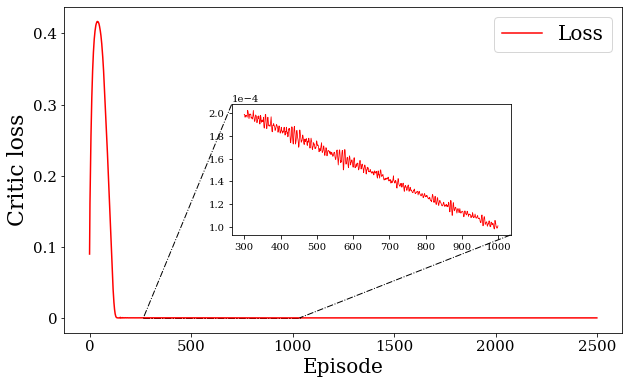

In [10]:
cri = np.mean(np.array(loss_critic).reshape(-1, N), 1)/(1e7 * sigma ** 2)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(cri, color = 'r', label='Loss')
axins = ax.inset_axes((0.3,0.3,0.5,0.4))
axins.plot(np.arange(300,1000), cri[300:1000], color='r', linewidth=0.8)
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='k', lw=1, color='pink', linestyle='-.')
axins.ticklabel_format(style='scientific', scilimits=(0,0), axis='y')
ax.set_xticklabels(np.arange(-500, 3001, 500), fontsize=15)
ax.set_yticklabels([-0.1,0,0.1,0.2,0.3,0.4], fontsize=15)
ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Critic loss', fontsize=22)

ax.legend(prop=fontdict_prop)
plt.savefig('3 dim critic loss.png', bbox_inches='tight', dpi=150)
plt.show()

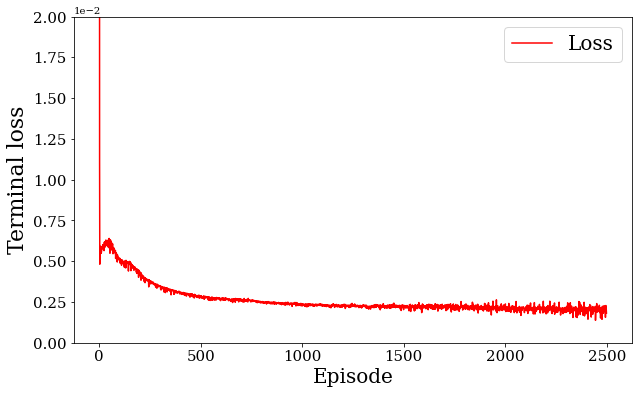

In [25]:
temp = np.array(loss_terminal).reshape(-1, N)
aa = []
for i in range(temp.shape[0]):
    aa.append(temp[i,0])
ter = np.array(aa)/(100 * 10**2)

plt.figure(figsize=(10, 6))
plt.plot(range(len(aa)), ter, label='Loss', color = 'r')
plt.ylim(0,0.02)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Terminal loss', fontsize=22)
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.legend(prop=fontdict_prop)
plt.savefig('3 dim loss_terminal.png', bbox_inches='tight', dpi=150)
plt.show()

/tmp/ipykernel_42983/2993036271.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(-500,3001,500), fontsize=15)
/tmp/ipykernel_42983/2993036271.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,45,5), fontsize=15)


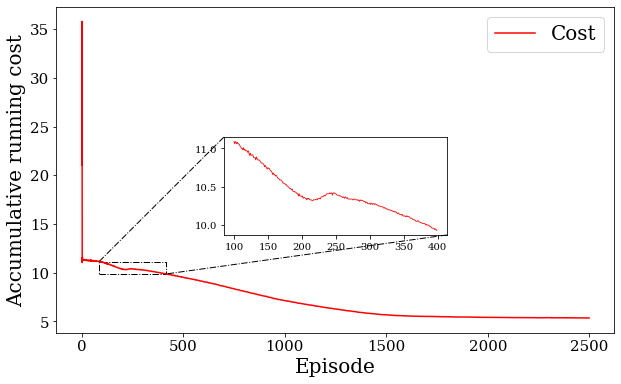

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(total_reward[:], color = 'r', label='Cost')
axins = ax.inset_axes((0.3,0.3,0.4,0.3))
axins.plot(np.arange(100,400), total_reward[100:400], color='r', linewidth=0.8)
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='k', lw=1, color='pink', linestyle='-.')
ax.set_xticklabels(np.arange(-500,3001,500), fontsize=15)
ax.set_yticklabels(np.arange(0,45,5), fontsize=15)
ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Accumulative running cost', fontsize=20)
ax.legend(prop=fontdict_prop)
plt.savefig('3 dim cost.png', bbox_inches='tight', dpi=150)
plt.show()

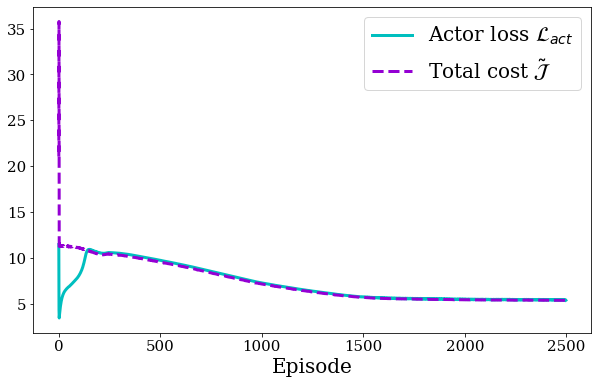

In [26]:
temp = np.array(loss_actor).reshape(-1, N)
aa = []
for i in range(temp.shape[0]):
    aa.append(temp[i,0])
act = np.array(aa)/500

plt.figure(figsize=(10, 6))
plt.plot(range(len(aa)), act, label=r'Actor loss $\mathcal{L}_{act}$', color = 'c', linewidth=3)
plt.plot(total_reward, label=r'Total cost $\tilde{\mathcal{J}}$', color='darkviolet', linestyle='--', linewidth=3)
# plt.ylim(2,15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Episode', fontsize=20)
# plt.ylabel('Actor loss', fontsize=22)
# plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.legend(prop=fontdict_prop)
plt.savefig('3 dim Q and J.png', bbox_inches='tight', dpi=150)
plt.show()

/tmp/ipykernel_42983/807378174.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


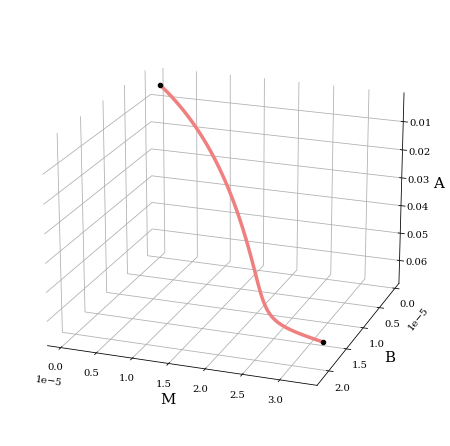

In [13]:
start = 2000
end = 2499
dd = memory[start].copy(deep=True)
for num in range(start + 1, end + 1):
    dd += memory[num] 
data = dd / (end - start + 1)        # average data
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
ax.scatter3D(data.iloc[0, 0], data.iloc[0, 1], data.iloc[0, 2], color='black', s=20)
ax.scatter3D(data.iloc[N-1, 0], data.iloc[N-1, 1], data.iloc[N-1, 2], color='black', s=20)
ax.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax.set_xlabel('M', fontsize=15)
ax.set_ylabel('B', fontsize=15)
ax.set_zlabel('A', fontsize=15)
ax.plot3D(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], color='lightcoral', linewidth=3.5)
ax.view_init(elev=200, azim=250)
plt.savefig('3 dim plot.png', bbox_inches='tight', dpi=150)
plt.show()

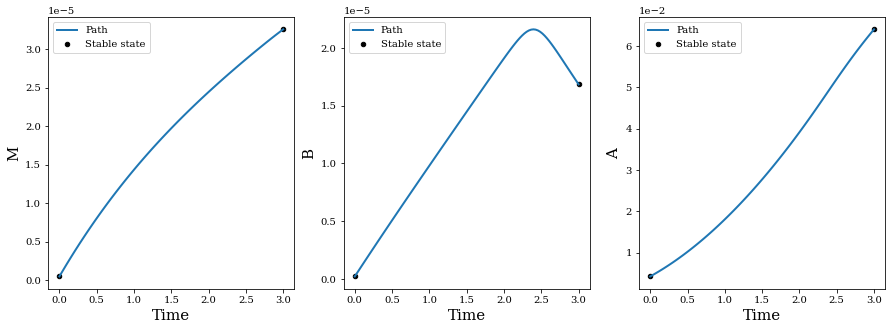

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
t = np.linspace(0, T, N)
plt.plot(t, data.iloc[:, 0],  linewidth=2, label='Path')
plt.xlabel('Time', fontsize=15)
plt.ylabel('M', fontsize=15)
plt.scatter(t[0], data.iloc[0, 0], color='black', s=20, label='Stable state')
plt.scatter(t[-1], data.iloc[-1, 0], color='black', s=20)
plt.legend()
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

plt.subplot(1, 3, 2)
plt.plot(t, data.iloc[:, 1], linewidth=2, label='Path')
plt.xlabel('Time', fontsize=15)
plt.ylabel('B', fontsize=15)
plt.scatter(t[0], data.iloc[0, 1], color='black', s=20, label='Stable state')
plt.scatter(t[-1], data.iloc[-1, 1], color='black', s=20)
plt.legend()
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

plt.subplot(1, 3, 3)
plt.plot(t, data.iloc[:, 2], linewidth=2, label='Path')
plt.xlabel('Time', fontsize=15)
plt.ylabel('A', fontsize=15)
plt.scatter(t[0], data.iloc[0, 2], color='black', s=20, label='Stable state')
plt.scatter(t[-1], data.iloc[-1, 2], color='black', s=20)
plt.legend()
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.savefig('3 dim path.png', bbox_inches='tight', dpi=150)
plt.show()